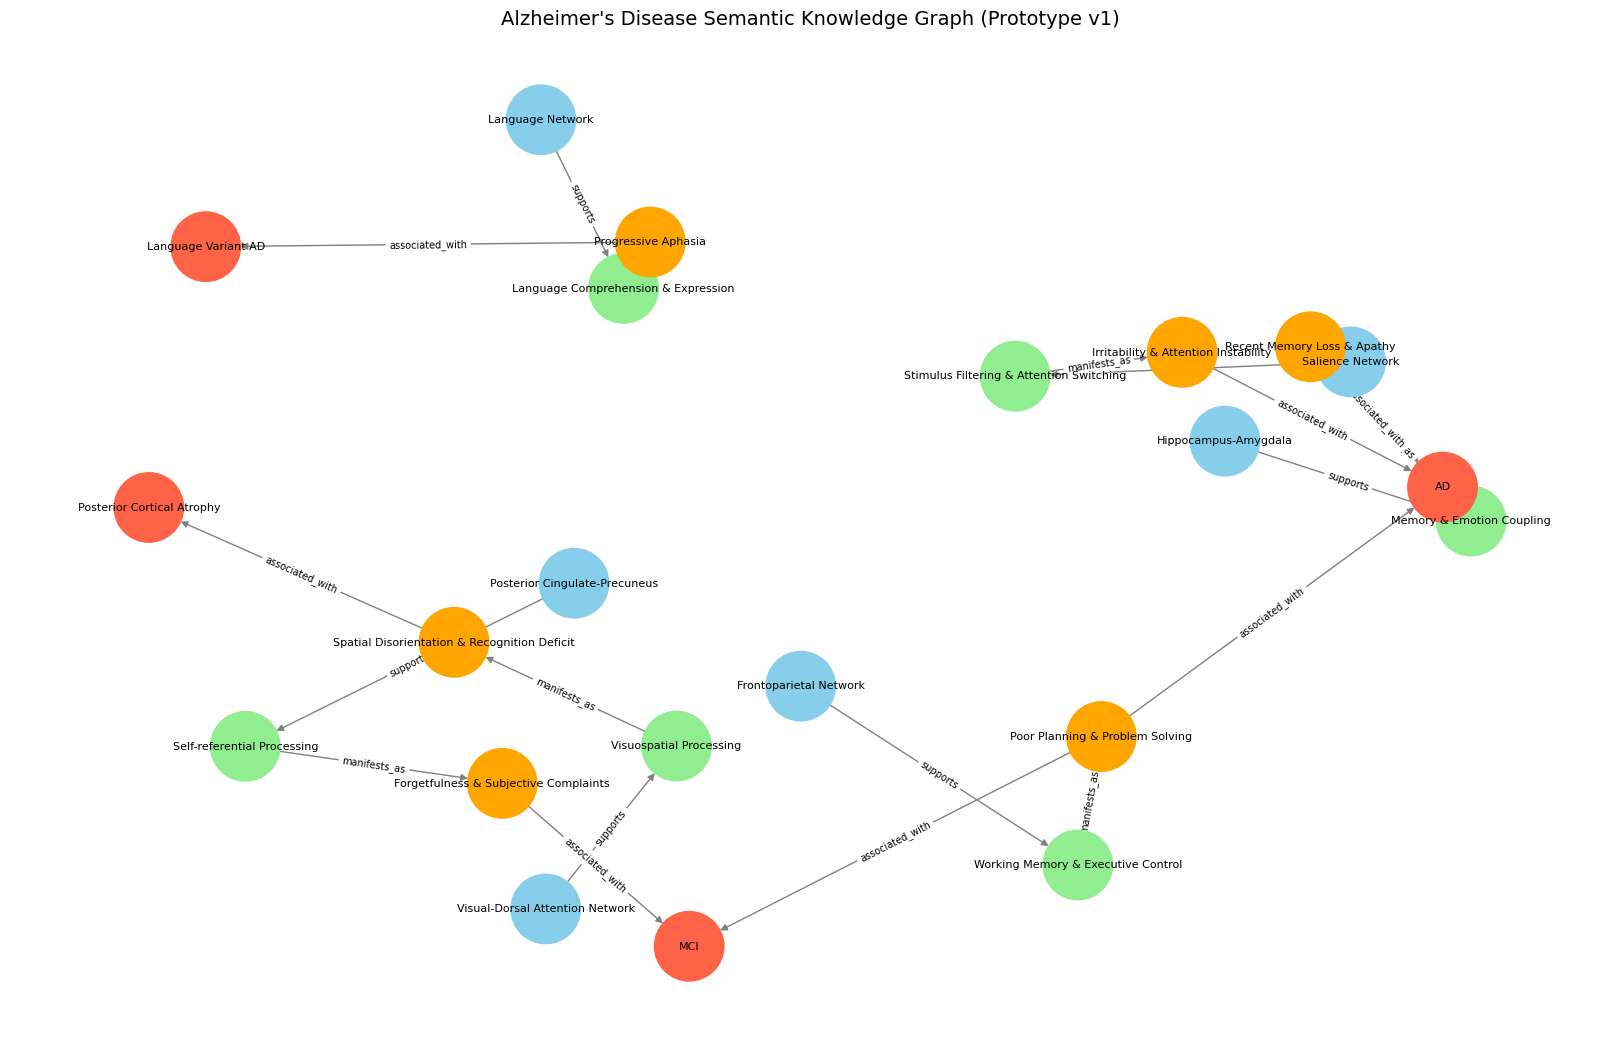

FileNotFoundError: [Errno 2] No such file or directory: '../graphql/alzheimers_kg_v1.graphml'

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# 建立有向圖
G = nx.DiGraph()

# 節點與類型
nodes = [
    # Region
    ("Hippocampus-Amygdala", {"type": "Region"}),
    ("Posterior Cingulate-Precuneus", {"type": "Region"}),
    ("Visual-Dorsal Attention Network", {"type": "Region"}),
    ("Frontoparietal Network", {"type": "Region"}),
    ("Salience Network", {"type": "Region"}),
    ("Language Network", {"type": "Region"}),

    # Function
    ("Memory & Emotion Coupling", {"type": "Function"}),
    ("Self-referential Processing", {"type": "Function"}),
    ("Visuospatial Processing", {"type": "Function"}),
    ("Working Memory & Executive Control", {"type": "Function"}),
    ("Stimulus Filtering & Attention Switching", {"type": "Function"}),
    ("Language Comprehension & Expression", {"type": "Function"}),

    # Symptom
    ("Recent Memory Loss & Apathy", {"type": "Symptom"}),
    ("Forgetfulness & Subjective Complaints", {"type": "Symptom"}),
    ("Spatial Disorientation & Recognition Deficit", {"type": "Symptom"}),
    ("Poor Planning & Problem Solving", {"type": "Symptom"}),
    ("Irritability & Attention Instability", {"type": "Symptom"}),
    ("Progressive Aphasia", {"type": "Symptom"}),

    # Disease
    ("MCI", {"type": "Disease"}),
    ("AD", {"type": "Disease"}),
    ("Posterior Cortical Atrophy", {"type": "Disease"}),
    ("Language Variant AD", {"type": "Disease"}),
]

# 邊與語意關係
edges = [
    ("Hippocampus-Amygdala", "Memory & Emotion Coupling", {"relation": "supports"}),
    ("Memory & Emotion Coupling", "Recent Memory Loss & Apathy", {"relation": "manifests_as"}),
    ("Recent Memory Loss & Apathy", "AD", {"relation": "associated_with"}),

    ("Posterior Cingulate-Precuneus", "Self-referential Processing", {"relation": "supports"}),
    ("Self-referential Processing", "Forgetfulness & Subjective Complaints", {"relation": "manifests_as"}),
    ("Forgetfulness & Subjective Complaints", "MCI", {"relation": "associated_with"}),

    ("Visual-Dorsal Attention Network", "Visuospatial Processing", {"relation": "supports"}),
    ("Visuospatial Processing", "Spatial Disorientation & Recognition Deficit", {"relation": "manifests_as"}),
    ("Spatial Disorientation & Recognition Deficit", "Posterior Cortical Atrophy", {"relation": "associated_with"}),

    ("Frontoparietal Network", "Working Memory & Executive Control", {"relation": "supports"}),
    ("Working Memory & Executive Control", "Poor Planning & Problem Solving", {"relation": "manifests_as"}),
    ("Poor Planning & Problem Solving", "MCI", {"relation": "associated_with"}),
    ("Poor Planning & Problem Solving", "AD", {"relation": "associated_with"}),

    ("Salience Network", "Stimulus Filtering & Attention Switching", {"relation": "supports"}),
    ("Stimulus Filtering & Attention Switching", "Irritability & Attention Instability", {"relation": "manifests_as"}),
    ("Irritability & Attention Instability", "AD", {"relation": "associated_with"}),

    ("Language Network", "Language Comprehension & Expression", {"relation": "supports"}),
    ("Language Comprehension & Expression", "Progressive Aphasia", {"relation": "manifests_as"}),
    ("Progressive Aphasia", "Language Variant AD", {"relation": "associated_with"}),
]

# 加入節點與邊
G.add_nodes_from(nodes)
G.add_edges_from([(u, v, d) for u, v, d in edges])

# 視覺化設定
type_colors = {
    "Region": "skyblue",
    "Function": "lightgreen",
    "Symptom": "orange",
    "Disease": "tomato"
}
node_colors = [type_colors[G.nodes[n]["type"]] for n in G.nodes]

# 畫圖
plt.figure(figsize=(16, 10))
pos = nx.spring_layout(G, seed=42, k=0.6)
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=2500, font_size=8, edge_color='gray')
edge_labels = nx.get_edge_attributes(G, "relation")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title("Alzheimer's Disease Semantic Knowledge Graph (Prototype v1)", fontsize=14)
plt.axis("off")
plt.show()

# 儲存為 .graphml
nx.write_graphml(G, "../graphql/alzheimers_kg_v1.graphml")


In [ ]:
import numpy as np
from nilearn import datasets
import nibabel as nib
from skimage.transform import resize
from collections import defaultdict

# 載入 activation map
act = np.load("../../hook/activation_conv2.npy")  # shape [50, H, W]
act_map = act.mean(axis=0)  # 聚合 channel，shape [H, W]

# 載入 AAL atlas
atlas = datasets.fetch_atlas_aal(version='SPM12')
aal_img = nib.load(atlas['maps'])
aal_data = aal_img.get_fdata()
aal_labels = atlas['labels']

z_slice = 50  # 假設這是你 activation 所對應的切片
aal_slice = aal_data[:, :, z_slice]  # shape [91, 109]

# resize 到 activation 大小
# 原始版本：
# resized_aal = resize(aal_slice, act_map.shape, order=0, preserve_range=True, anti_aliasing=False).astype(int)

# 改進版：保證輸出是純整數且 shape 正確
resized_aal = resize(
    aal_slice,
    act_map.shape,
    order=0,
    preserve_range=True,
    anti_aliasing=False
)

# 把小數強制轉為最近整數，再轉為 int（避免 label = 2.00001 這種浮點誤差）
resized_aal = np.rint(resized_aal).astype(int)

region_activation = defaultdict(list)

for i in range(act_map.shape[0]):
    for j in range(act_map.shape[1]):
        value = resized_aal[i, j]

        # 如果是 numpy 陣列，確認是大小為 1 才轉 scalar
        if isinstance(value, np.ndarray):
            if value.size == 1:
                label_id = int(value.flat[0])
            else:
                continue  # 多維陣列就跳過
        else:
            try:
                label_id = int(value)
            except (ValueError, TypeError):
                continue  # 無法轉換就跳過

        # 篩掉背景（label_id <= 0）
        if label_id > 0:
            region_activation[label_id].append(act_map[i, j])


# 平均每個腦區 activation
region_mean_activation = {label_id: np.mean(vals) for label_id, vals in region_activation.items()}

# 排名前幾高的腦區
top_regions = sorted(region_mean_activation.items(), key=lambda x: x[1], reverse=True)[:5]
top_named_regions = [(aal_labels[rid - 1], score) for rid, score in top_regions]

print("🧠 高活化腦區：")
for name, score in top_named_regions:
    print(f"{name}: {score:.4f}")

kg_regions = [n for n, d in G.nodes(data=True) if d['type'] == 'Region']

# 嘗試對應名稱（你可以做簡化比對，例如 substring matching）
for name, score in top_named_regions:
    for kg_node in kg_regions:
        if name.lower() in kg_node.lower() or kg_node.lower() in name.lower():
            print(f"✅ 對應 KG node: {kg_node} (activation: {score:.4f})")


[get_dataset_dir] Dataset found in /Users/morris/nilearn_data/aal_SPM12
🧠 高活化腦區：


TypeError: Invalid shape (50, 9, 9) for image data

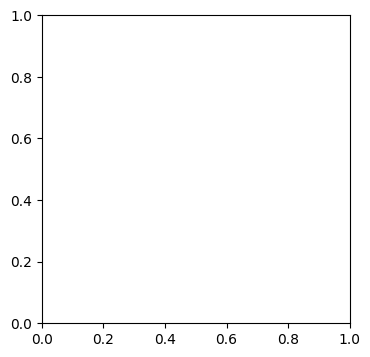

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(act_map, cmap='hot')  # 這裡是 2D 的 activation map
plt.title("Activation Map")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(resized_aal, cmap='tab20')  # 這是經過 resize 的 AAL label map
plt.title("Resized AAL Slice")
plt.axis('off')

plt.tight_layout()
plt.show()


In [21]:
print("act shape:", act.shape)         # 預期為 (50, 9, 9)
print("act_map shape:", act_map.shape) # 預期為 (9, 9)


act shape: (1, 50, 9, 9)
act_map shape: (50, 9, 9)


In [22]:
# DEBUG: 檢查 label 是否合理
print("activation map shape:", act_map.shape)
print("AAL slice shape:", aal_slice.shape)
print("resized AAL unique labels:", np.unique(resized_aal))
print("activation map 非零比例：", np.count_nonzero(act_map) / act_map.size)


activation map shape: (50, 9, 9)
AAL slice shape: (91, 109)
resized AAL unique labels: [   0 2001 2002 2101 2102 2201 2202 2301 2302 2311 2312 2601 2602 4001
 4002 4021 4022 5011 5012 5101 5102 5201 5202 6001 6211 6212 6221 6222
 6301 6302]
activation map 非零比例： 1.0


In [26]:
import numpy as np

act = np.load("../../hook/activation_conv2.npy")  # (50, 9, 9)
print("act shape:", act.shape)

act_map = act.mean(axis=0)
print("✅ act_map shape:", act_map.shape)

# 防呆 check：明確指出你拿的是誰
print("📢 act_map type:", type(act_map))
print("📢 act_map ndim:", act_map.ndim)
print("📢 act_map shape:", act_map.shape)
print("📢 act_map dtype:", act_map.dtype)

# 安全可視化：只有 ndim=2 才能畫
if act_map.ndim == 2:
    import matplotlib.pyplot as plt
    plt.imshow(act_map, cmap='hot')
    plt.title("✅ Activation Map")
    plt.axis('off')
    plt.show()
else:
    print("❌ act_map 不是 2D，你傳進的是錯的東西！")


act shape: (1, 50, 9, 9)
✅ act_map shape: (50, 9, 9)
📢 act_map type: <class 'numpy.ndarray'>
📢 act_map ndim: 3
📢 act_map shape: (50, 9, 9)
📢 act_map dtype: float32
❌ act_map 不是 2D，你傳進的是錯的東西！


Squeezed act shape: (50, 9, 9)
act_map shape: (9, 9)
[get_dataset_dir] Dataset found in /Users/morris/nilearn_data/aal_SPM12
act_map min/max: -0.08329132 -0.08329132


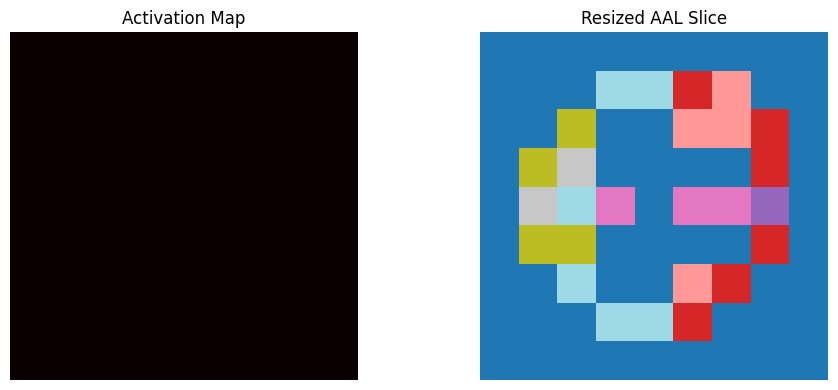

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
import nibabel as nib
from skimage.transform import resize

# === Step 1: Load activation ===
act = np.load("../../hook/activation_conv2.npy")  # shape: (1, 50, 9, 9)
act = np.squeeze(act)  # shape: (50, 9, 9)
print("Squeezed act shape:", act.shape)

act_map = act.mean(axis=0)  # shape: (9, 9)
print("act_map shape:", act_map.shape)

# === Step 2: Load atlas and slice ===
atlas = datasets.fetch_atlas_aal(version='SPM12')
aal_img = nib.load(atlas['maps'])
aal_data = aal_img.get_fdata()
aal_labels = atlas['labels']

z_slice = 50
aal_slice = aal_data[:, :, z_slice]  # shape: (91, 109)
resized_aal = resize(
    aal_slice, act_map.shape, order=0, preserve_range=True, anti_aliasing=False
)
resized_aal = np.rint(resized_aal).astype(int)

# === Step 3: Visual check ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(act_map, cmap='hot')
print("act_map min/max:", act_map.min(), act_map.max())
plt.title("Activation Map")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(resized_aal, cmap='tab20')
plt.title("Resized AAL Slice")
plt.axis('off')

plt.tight_layout()
plt.show()


In [31]:
from collections import defaultdict

# 重新計算 region activation
region_activation = defaultdict(list)

for i in range(act_map.shape[0]):
    for j in range(act_map.shape[1]):
        label_id = resized_aal[i, j]
        if label_id > 0:
            region_activation[label_id].append(act_map[i, j])

# 計算平均
region_mean = {k: np.mean(v) for k, v in region_activation.items()}
top5 = sorted(region_mean.items(), key=lambda x: x[1], reverse=True)[:5]

# 正確對應 label 名稱
label_dict = {int(k): v for k, v in zip(atlas['indices'], atlas['labels'])}

print("🧠 Top activated brain regions:")
for label_id, score in top5:
    label_name = label_dict.get(label_id, "Unknown")
    print(f"{label_name} ({label_id}): {score:.4f}")


🧠 Top activated brain regions:
SupraMarginal_R (6212): -0.0833
Precentral_R (2002): -0.0833
Frontal_Inf_Tri_R (2312): -0.0833
Occipital_Mid_R (5202): -0.0833
Frontal_Inf_Oper_R (2302): -0.0833
